In [1]:
# Install library
!pip install -q google-play-scraper transformers datasets scikit-learn wordcloud

# Import Library
from google_play_scraper import reviews, Sort
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from wordcloud import WordCloud
from transformers import DataCollatorWithPadding
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from datasets import Dataset, ClassLabel
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00


## DATA UNDERSTANDING

In [2]:
# Load data
data = pd.read_csv('mytelkomsel.csv')
data.head()

,ulasan,rating,tanggal
0,sinyal ampas,1,2025-07-05 14:02:41
1,"sinyal parah kadang muncul ,,lebih sering ilan...",1,2025-07-05 14:02:01
2,my telkomsel versi paling buruk Terburuk..tida...,1,2025-07-05 14:01:59
3,jaringan sangat bagus,5,2025-07-05 14:01:26
4,"telomsel jaringan sangat buruk , apa telomsel ...",1,2025-07-05 14:01:05


In [3]:
# Eksplorasi data
print("\n Informasi Dataset:")
print(f"- Jumlah baris dan kolom: {data.shape}")
print(f"- Kolom yang tersedia: {list(data.columns)}")

print("\n Tipe Data:")
print(data.dtypes)

print("\n Data Kosong:")
print(data.isnull().sum())

print("\n Statistik Deskriptif:")
print(data.describe())


 Informasi Dataset:
- Jumlah baris dan kolom: (10000, 3)
- Kolom yang tersedia: ['ulasan', 'rating', 'tanggal']

 Tipe Data:
ulasan     object
rating      int64
tanggal    object
dtype: object

 Data Kosong:
ulasan     0
rating     0
tanggal    0
dtype: int64

 Statistik Deskriptif:
             rating
count  10000.000000
mean       2.269500
std        1.704864
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max        5.000000


In [4]:
# Analisis distribusi rating
print("\n Distribusi Rating:")
print(data['rating'].value_counts().sort_index())


 Distribusi Rating:
rating
1    5825
2     905
3     492
4     306
5    2472
Name: count, dtype: int64


/tmp/ipython-input-5-3511108134.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=data, palette='viridis')


Text(0, 0.5, 'Jumlah')

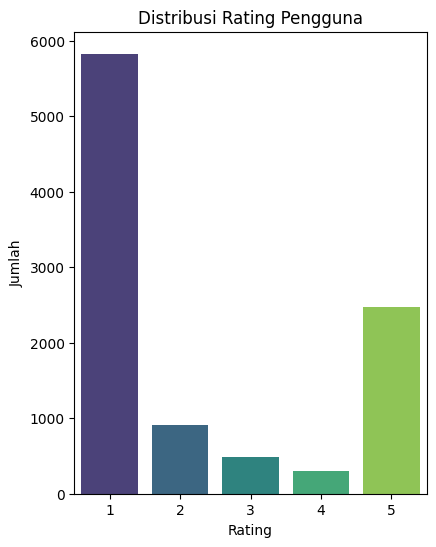

In [5]:
# Visualisasi distribusi rating
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='rating', data=data, palette='viridis')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah')


WordCloud - Kata yang Sering Muncul:


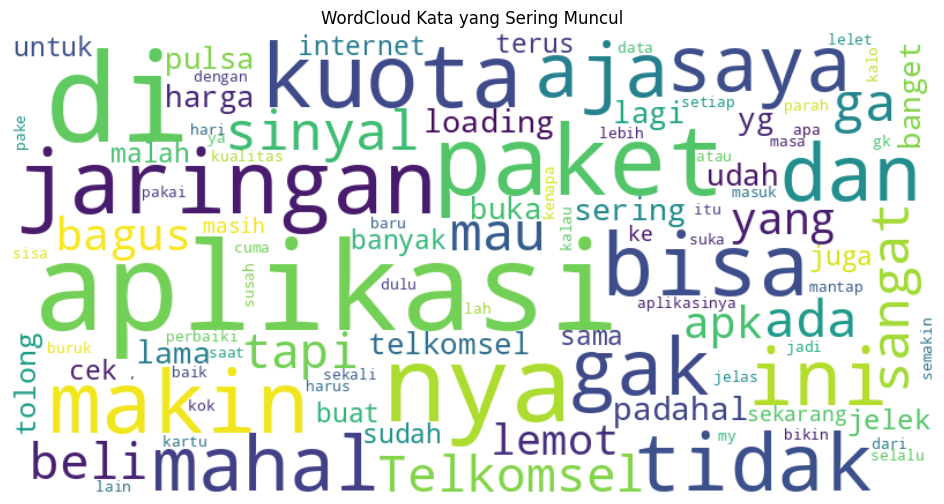

In [6]:
# WordCloud untuk memahami kata-kata yang sering muncul
print("\nWordCloud - Kata yang Sering Muncul:")
text_combined = " ".join(data['ulasan'].astype(str).tolist())
words = text_combined.split()
word_freq = pd.Series(words).value_counts().to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='white',
                     colormap='viridis', max_words=100).generate_from_frequencies(word_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Kata yang Sering Muncul')
plt.show()

## DATA PREPARATION

In [7]:
# Pembersihan teks
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Konversi ke huruf kecil
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Hapus URL
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
        text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
        return text
    else:
        return ""

data['clean_ulasan'] = data['ulasan'].apply(clean_text)

In [8]:
# Labeling sentimen berdasarkan rating
def label_sentiment(rating):
    if rating >= 4:
        return 'positif'
    elif rating == 3:
        return 'netral'
    else:
        return 'negatif'

data['label'] = data['rating'].apply(label_sentiment)

print("Distribusi sentimen sebelum preprocessing:")
print(data['label'].value_counts())

Distribusi sentimen sebelum preprocessing:
label
negatif    6730
positif    2778
netral      492
Name: count, dtype: int64


In [9]:
# Filter data dengan ulasan yang terlalu pendek
data_filtered = data[data['clean_ulasan'].str.len() > 5].copy()
print(f"Data setelah filtering: {data_filtered.shape[0]} dari {data.shape[0]} data")

Data setelah filtering: 9162 dari 10000 data


In [10]:
# Penanganan imbalanced data (oversampling untuk kelas minoritas)
print("Menangani ketidakseimbangan kelas...")
print("Distribusi sebelum oversampling:")
print(data_filtered['label'].value_counts())

# Memisahkan data ke dalam tiga subset berdasarkan label
netral_df = data_filtered[data_filtered['label'] == 'netral']
negatif_df = data_filtered[data_filtered['label'] == 'negatif']
positif_df = data_filtered[data_filtered['label'] == 'positif']

# Menentukan jumlah target sample untuk setiap kelas
target_samples = max(len(negatif_df), len(positif_df))

# Oversampling data netral agar jumlahnya setara dengan kelas terbanyak
oversampled_netral = netral_df.sample(n=target_samples, replace=True, random_state=42)

# Menggabungkan data negatif, positif, dan netral (yang sudah di-oversample)
data_balanced = pd.concat([negatif_df, positif_df, oversampled_netral]).reset_index(drop=True)

print("Distribusi setelah oversampling:")
print(data_balanced['label'].value_counts())

Menangani ketidakseimbangan kelas...
Distribusi sebelum oversampling:
label
negatif    6599
positif    2092
netral      471
Name: count, dtype: int64
Distribusi setelah oversampling:
label
negatif    6599
netral     6599
positif    2092
Name: count, dtype: int64


In [11]:
# Encoding label
label2id = {'negatif': 0, 'netral': 1, 'positif': 2}
id2label = {0: 'negatif', 1: 'netral', 2: 'positif'}
data_balanced['label_id'] = data_balanced['label'].map(label2id).astype('int64')


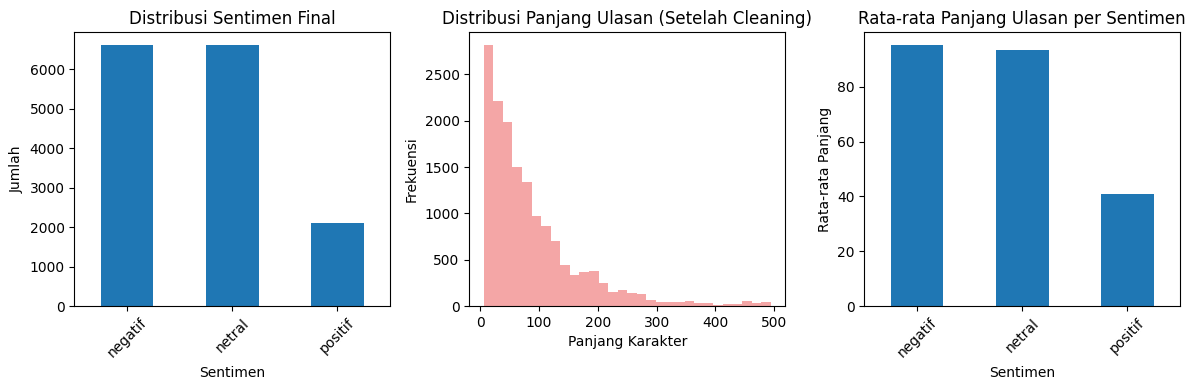

In [12]:
# Visualisasi hasil preprocessing
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
data_balanced['label'].value_counts().plot(kind='bar', title='Distribusi Sentimen Final')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
data_balanced['panjang_ulasan'] = data_balanced['clean_ulasan'].str.len()
plt.hist(data_balanced['panjang_ulasan'], bins=30, alpha=0.7, color='lightcoral')
plt.title('Distribusi Panjang Ulasan (Setelah Cleaning)')
plt.xlabel('Panjang Karakter')
plt.ylabel('Frekuensi')

plt.subplot(1, 3, 3)
sample_lengths = data_balanced.groupby('label')['panjang_ulasan'].mean()
sample_lengths.plot(kind='bar', title='Rata-rata Panjang Ulasan per Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Rata-rata Panjang')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## MODELING

In [13]:
# Persiapan tokenizer dan model
print("Memuat tokenizer dan model IndoBERT...")
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)


Memuat tokenizer dan model IndoBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Split dataset data latih (80%) dan data uji (20%).
train_df, test_df = train_test_split(data_balanced, test_size=0.2, stratify=data_balanced['label_id'], random_state=42)

In [15]:
# Konversi DataFrame ke dataset HuggingFace
train_dataset = Dataset.from_pandas(train_df[['clean_ulasan', 'label_id']])
test_dataset = Dataset.from_pandas(test_df[['clean_ulasan', 'label_id']])

# Ganti nama kolom agar sesuai dengan standar HuggingFace (text dan label)
train_dataset = train_dataset.rename_columns({'clean_ulasan': 'text', 'label_id': 'label'})
test_dataset = test_dataset.rename_columns({'clean_ulasan': 'text', 'label_id': 'label'})

# Konversi label menjadi ClassLabel agar dikenali sebagai kelas kategori
features = train_dataset.features.copy()
features['label'] = ClassLabel(names=['negatif', 'netral', 'positif'])
train_dataset = train_dataset.cast(features)
test_dataset = test_dataset.cast(features)


Casting the dataset:   0%|          | 0/12232 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3058 [00:00<?, ? examples/s]

In [16]:
# Tokenisasi
def tokenize_function(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

print("Melakukan tokenisasi...")
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Melakukan tokenisasi...


Map:   0%|          | 0/12232 [00:00<?, ? examples/s]

Map:   0%|          | 0/3058 [00:00<?, ? examples/s]

In [17]:
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
# Fungsi evaluasi
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [19]:
# Konfigurasi training
print("Konfigurasi training...")
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    report_to=None,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Training model
trainer.train()

Konfigurasi training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mc009d5y2044 (mc012d5y2159-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.205700,0.344160,0.906148
2,0.149500,0.267966,0.939830
3,0.106800,0.287590,0.940811


TrainOutput(global_step=4587, training_loss=0.27154358029154385, metrics={'train_runtime': 989.0872, 'train_samples_per_second': 37.101, 'train_steps_per_second': 4.638, 'total_flos': 2086045398690624.0, 'train_loss': 0.27154358029154385, 'epoch': 3.0})

## EVALUATION

In [20]:
# Prediksi pada test set
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Evaluasi model
print("Hasil Evaluasi Model:")
accuracy = accuracy_score(y_true, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%")

Hasil Evaluasi Model:
Akurasi Model: 94.08%


In [21]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["negatif", "netral", "positif"]))

Classification Report:
              precision    recall  f1-score   support

     negatif       0.95      0.94      0.94      1320
      netral       0.96      0.99      0.98      1320
     positif       0.84      0.80      0.82       418

    accuracy                           0.94      3058
   macro avg       0.92      0.91      0.91      3058
weighted avg       0.94      0.94      0.94      3058



Confusion Matrix:


<Figure size 800x600 with 0 Axes>

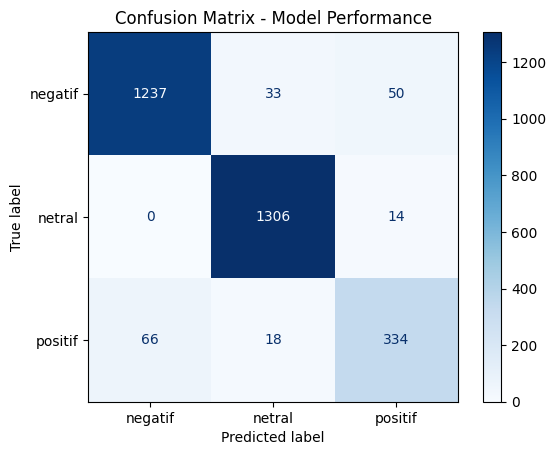

In [22]:
# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negatif", "netral", "positif"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Model Performance")
plt.show()

In [23]:
# Analisis per kelas
print(" Analisis Performa per Kelas:")
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
results_df = pd.DataFrame({
    'Kelas': ['negatif', 'netral', 'positif'],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print(results_df)

 Analisis Performa per Kelas:
     Kelas  Precision    Recall  F1-Score  Support
0  negatif   0.949348  0.937121  0.943195     1320
1   netral   0.962417  0.989394  0.975719     1320
2  positif   0.839196  0.799043  0.818627      418


In [24]:
# Analisis kesalahan prediksi
print("Analisis Kesalahan Prediksi:")
test_df = test_dataset.to_pandas()
test_df['y_true'] = y_true
test_df['y_pred'] = y_pred
test_df['true_label'] = test_df['y_true'].map(id2label)
test_df['pred_label'] = test_df['y_pred'].map(id2label)

# Contoh kesalahan prediksi
wrong_predictions = test_df[test_df['y_true'] != test_df['y_pred']]
print(f"Jumlah kesalahan prediksi: {len(wrong_predictions)}")

if len(wrong_predictions) > 0:
    print("\nContoh kesalahan prediksi:")
    for i, row in wrong_predictions.head(5).iterrows():
        print(f"Teks: {row['text'][:100]}...")
        print(f"Label True: {row['true_label']}, Prediksi: {row['pred_label']}")
        print("-" * 80)


Analisis Kesalahan Prediksi:
Jumlah kesalahan prediksi: 181

Contoh kesalahan prediksi:
Teks: akhir akhir ini kok bermasalah apk nya bisa bantu jelaskan kenapa...
Label True: positif, Prediksi: negatif
--------------------------------------------------------------------------------
Teks: pengennya apa sih ini aplikasidari kemarin kemarin loading mulu...
Label True: positif, Prediksi: negatif
--------------------------------------------------------------------------------
Teks: telkomsel tolong jaringan nya di perbaiki lelet kali jangan kalah sama yang sebelah...
Label True: positif, Prediksi: netral
--------------------------------------------------------------------------------
Teks: bagaimana ini kenapa belum juga masuk rewardnya selamat soresaya mau menanyakan terkait laporan kelu...
Label True: negatif, Prediksi: positif
--------------------------------------------------------------------------------
Teks: aplikasi lemot sekali...
Label True: negatif, Prediksi: netral
-------------

## INFERENCE

In [25]:
# Setup model untuk inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sentiment(text, return_confidence=False):

    # Preprocessing teks
    cleaned_text = clean_text(text)

    # Tokenisasi
    inputs = tokenizer(cleaned_text, return_tensors="pt",
                      truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    predicted_label = id2label[predicted_class]

    if return_confidence:
        return predicted_label, confidence
    else:
        return predicted_label

def predict_with_probabilities(text):

    cleaned_text = clean_text(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt",
                      truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    prob_dict = {}
    for i, label in id2label.items():
        prob_dict[label] = probabilities[0][i].item()

    return prob_dict


In [26]:
test_sentences = [
    "Aplikasinya sangat bagus, saya suka!",
    "Buruk sekali, bikin kesel.",
    "Lumayan.",
    "Kenapa aplikasi ini lag banget ya?",
    "CS nya ramah banget, mantap.",
    "Bayar paket gagal terus!",
]

for text in test_sentences:
    sentiment, confidence = predict_sentiment(text, return_confidence=True)
    print(f"Teks: {text}")
    print(f"Prediksi: {sentiment} (Confidence: {confidence:.2f})")
    print("-" * 40)


Teks: Aplikasinya sangat bagus, saya suka!
Prediksi: positif (Confidence: 1.00)
----------------------------------------
Teks: Buruk sekali, bikin kesel.
Prediksi: negatif (Confidence: 1.00)
----------------------------------------
Teks: Lumayan.
Prediksi: netral (Confidence: 0.99)
----------------------------------------
Teks: Kenapa aplikasi ini lag banget ya?
Prediksi: netral (Confidence: 1.00)
----------------------------------------
Teks: CS nya ramah banget, mantap.
Prediksi: positif (Confidence: 1.00)
----------------------------------------
Teks: Bayar paket gagal terus!
Prediksi: negatif (Confidence: 1.00)
----------------------------------------


In [27]:
# Interface interaktif
print("Interface Interaktif:")
print("Silakan masukkan ulasan untuk diprediksi sentimennya!")
print("Ketik 'stop' untuk keluar")

while True:
    user_input = input("\nMasukkan ulasan: ")
    if user_input.lower() == 'stop':
        break

    if user_input.strip():
        sentiment, confidence = predict_sentiment(user_input, return_confidence=True)
        print(f"Sentimen: {sentiment}")
        print(f"Confidence: {confidence:.2f}")
    else:
        print("Silakan masukkan teks yang valid!")

Interface Interaktif:
Silakan masukkan ulasan untuk diprediksi sentimennya!
Ketik 'stop' untuk keluar

Masukkan ulasan: Aplikasinya sangat membantu, tampilannya keren dan mudah digunakan.
Sentimen: positif
Confidence: 1.00

Masukkan ulasan: Aplikasinya sering force close, tolong segera diperbaiki
Sentimen: negatif
Confidence: 0.98

Masukkan ulasan: Tampilan aplikasinya bagus, tapi lemot
Sentimen: netral
Confidence: 0.62

Masukkan ulasan: stop
